In [1]:
"""
NOTEBOOK 01: DATA EXPLORATION

Purpose: Comprehensive exploratory analysis of Ma3Route Nairobi crash dataset
         to understand patterns, quality, and suitability for binary severity prediction

Author: Mary Wangoi Mwangi (122174)
Supervisor: Prof. Vincent Omwenga
Date: January 2026
"""

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set visualization style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure matplotlib for better-looking plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10

print(" Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

 Libraries imported successfully
Analysis Date: 2026-02-09 19:55


In [4]:
"""
SECTION 2: Load Raw Ma3Route Dataset

This cell loads the downloaded Ma3Route crash dataset from World Bank.
Dataset contains 10 variables: location, time, and keyword flags indicating
crash characteristics (fatality words, pedestrian, matatu, motorcycle).

NOTE: Raw dataset does NOT contain severity labels - these will be created
      using a domain-knowledge based classification logic in subsequent cells.

Source: World Bank Microdata Library
Dataset: Kenya - Road Traffic Crashes 2012-2023
"""

# Load raw Ma3Route dataset (algorithm-coded version)
data_path = '../data/raw/ma3route_crashes_2012_2023/ma3route_crashes_algorithmcode.csv'
df = pd.read_csv(data_path)

# Convert datetime columns
df['crash_datetime'] = pd.to_datetime(df['crash_datetime'])
df['crash_date'] = pd.to_datetime(df['crash_date'])

# Display dataset overview
print("="*70)
print("RAW MA3ROUTE DATASET LOADED")
print("="*70)
print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date Range: {df['crash_date'].min().date()} to {df['crash_date'].max().date()}")
print(f"Date Span: {(df['crash_date'].max() - df['crash_date'].min()).days} days")

# Display column inventory
print("\n" + "="*70)
print("COLUMN INVENTORY (10 Variables from World Bank)")
print("="*70)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col:30s} - {df[col].dtype}")

# Display keyword flag distributions
print("\n" + "="*70)
print("KEYWORD FLAG DISTRIBUTIONS")
print("="*70)
keyword_cols = ['contains_fatality_words', 'contains_pedestrian_words', 
                'contains_matatu_words', 'contains_motorcycle_words']

for col in keyword_cols:
    count = df[col].sum()
    pct = (count / len(df)) * 100
    print(f"{col:35s}: {count:5d} ({pct:5.2f}%)")

# Show sample records
print("\n" + "="*70)
print("SAMPLE RECORDS (First 5 Rows)")
print("="*70)
print(df.head().to_string())

print("\n Raw data loading complete")
print(" NOTE: Severity labels will be created in next section using keyword flags")

RAW MA3ROUTE DATASET LOADED

Dataset Shape: 31,064 rows × 10 columns
Memory Usage: 2.37 MB
Date Range: 2012-08-08 to 2023-07-12
Date Span: 3990 days

COLUMN INVENTORY (10 Variables from World Bank)
 1. crash_id                       - int64
 2. crash_datetime                 - datetime64[ns]
 3. crash_date                     - datetime64[ns]
 4. latitude                       - float64
 5. longitude                      - float64
 6. n_crash_reports                - int64
 7. contains_fatality_words        - int64
 8. contains_pedestrian_words      - int64
 9. contains_matatu_words          - int64
10. contains_motorcycle_words      - int64

KEYWORD FLAG DISTRIBUTIONS
contains_fatality_words            :  2284 ( 7.35%)
contains_pedestrian_words          :   944 ( 3.04%)
contains_matatu_words              :  2541 ( 8.18%)
contains_motorcycle_words          :  1142 ( 3.68%)

SAMPLE RECORDS (First 5 Rows)
   crash_id      crash_datetime crash_date  latitude  longitude  n_crash_reports  c

In [5]:
"""
SECTION 3: Create Severity Labels Using Keyword Flags

This section creates severity labels using domain-knowledge classification logic.
The World Bank Ma3Route dataset only provides keyword flags, not severity labels.

Classification Logic (based on emergency medicine literature):
- FATAL: Contains fatality keywords (dead, died, killed, fatal)
- SEVERE: Pedestrian or motorcycle crashes (vulnerable road users, high injury risk)
- MODERATE: Matatu crashes (public transport, multiple casualties)
- MINOR: No specific high-risk indicators

After creating 4-class labels, we collapse into BINARY classification:
- HIGH: Fatal + Severe (urgent response required)
- LOW: Moderate + Minor (standard response)

This binary approach matches operational emergency dispatch reality.
"""

# Create 4-class severity labels based on keyword flags
def assign_severity_4class(row):
    """
    Assign severity based on World Bank keyword flags.
    Priority order matters: fatality > pedestrian/motorcycle > matatu > minor
    """
    if row['contains_fatality_words'] == 1:
        return 'FATAL'
    elif row['contains_pedestrian_words'] == 1 or row['contains_motorcycle_words'] == 1:
        return 'SEVERE'  # Vulnerable road users
    elif row['contains_matatu_words'] == 1:
        return 'MODERATE'  # Public transport
    else:
        return 'MINOR'  # Default

# Apply severity classification
df['severity_4class'] = df.apply(assign_severity_4class, axis=1)

# Display 4-class distribution
print("="*70)
print("4-CLASS SEVERITY DISTRIBUTION")
print("="*70)
print(df['severity_4class'].value_counts().sort_index())
print(f"\nTotal: {len(df):,} crashes")

# Calculate percentages
print("\n" + "="*70)
print("4-CLASS SEVERITY PERCENTAGES")
print("="*70)
for severity in ['FATAL', 'SEVERE', 'MODERATE', 'MINOR']:
    count = (df['severity_4class'] == severity).sum()
    pct = (count / len(df)) * 100
    print(f"{severity:10s}: {count:6,} ({pct:5.2f}%)")

# Create BINARY severity classification (KEY FOR MODEL)
print("\n" + "="*70)
print("CREATING BINARY CLASSIFICATION (HIGH vs LOW)")
print("="*70)

def assign_binary_severity(severity_4class):
    """
    Collapse 4-class severity into binary classification for emergency dispatch.
    
    HIGH = FATAL + SEVERE (urgent response - ALS ambulance)
    LOW  = MODERATE + MINOR (standard response - BLS ambulance)
    """
    if severity_4class in ['FATAL', 'SEVERE']:
        return 'HIGH'
    else:
        return 'LOW'

# Apply binary classification
df['severity_binary'] = df['severity_4class'].apply(assign_binary_severity)

# Display binary distribution
print("\nBinary Distribution:")
print(df['severity_binary'].value_counts())

# Calculate percentages
print("\n" + "="*70)
print("BINARY SEVERITY PERCENTAGES")
print("="*70)
for severity in ['HIGH', 'LOW']:
    count = (df['severity_binary'] == severity).sum()
    pct = (count / len(df)) * 100
    print(f"{severity:10s}: {count:6,} ({pct:5.2f}%)")

# Show class imbalance ratio
high_count = (df['severity_binary'] == 'HIGH').sum()
low_count = (df['severity_binary'] == 'LOW').sum()
imbalance_ratio = low_count / high_count
print(f"\nClass Imbalance Ratio (LOW:HIGH): {imbalance_ratio:.2f}:1")

# Cross-tabulation: 4-class vs Binary
print("\n" + "="*70)
print("CROSS-TABULATION: 4-Class vs Binary")
print("="*70)
print(pd.crosstab(df['severity_4class'], df['severity_binary'], margins=True))

# Show sample records with severity labels
print("\n" + "="*70)
print("SAMPLE RECORDS WITH SEVERITY LABELS")
print("="*70)
cols_to_show = ['crash_id', 'crash_date', 'contains_fatality_words', 
                'contains_pedestrian_words', 'contains_motorcycle_words',
                'contains_matatu_words', 'severity_4class', 'severity_binary']
print(df[cols_to_show].head(10).to_string(index=False))

print("\n Severity labels created successfully")
print(f" Dataset now has {len(df.columns)} columns (added severity_4class and severity_binary)")

4-CLASS SEVERITY DISTRIBUTION
severity_4class
FATAL        2284
MINOR       25059
MODERATE     2121
SEVERE       1600
Name: count, dtype: int64

Total: 31,064 crashes

4-CLASS SEVERITY PERCENTAGES
FATAL     :  2,284 ( 7.35%)
SEVERE    :  1,600 ( 5.15%)
MODERATE  :  2,121 ( 6.83%)
MINOR     : 25,059 (80.67%)

CREATING BINARY CLASSIFICATION (HIGH vs LOW)

Binary Distribution:
severity_binary
LOW     27180
HIGH     3884
Name: count, dtype: int64

BINARY SEVERITY PERCENTAGES
HIGH      :  3,884 (12.50%)
LOW       : 27,180 (87.50%)

Class Imbalance Ratio (LOW:HIGH): 7.00:1

CROSS-TABULATION: 4-Class vs Binary
severity_binary  HIGH    LOW    All
severity_4class                    
FATAL            2284      0   2284
MINOR               0  25059  25059
MODERATE            0   2121   2121
SEVERE           1600      0   1600
All              3884  27180  31064

SAMPLE RECORDS WITH SEVERITY LABELS
 crash_id crash_date  contains_fatality_words  contains_pedestrian_words  contains_motorcycle_words 

TEMPORAL FEATURES CREATED
Date range: 2012 to 2023
Total years: 12

✓ Added features: hour, day_of_week, day_name, month, year, is_weekend

HOURLY CRASH DISTRIBUTION
      total_crashes  high_severity_crashes  high_severity_rate
hour                                                          
0               271                     35           12.915129
1               189                     21           11.111111
2               146                     22           15.068493
3               129                     15           11.627907
4               161                     20           12.422360
5               576                     65           11.284722
6              2654                    254            9.570460
7              2984                    349           11.695710
8              2174                    246           11.315547
9              1597                    225           14.088917
10             1374                    192           13.973799
11             

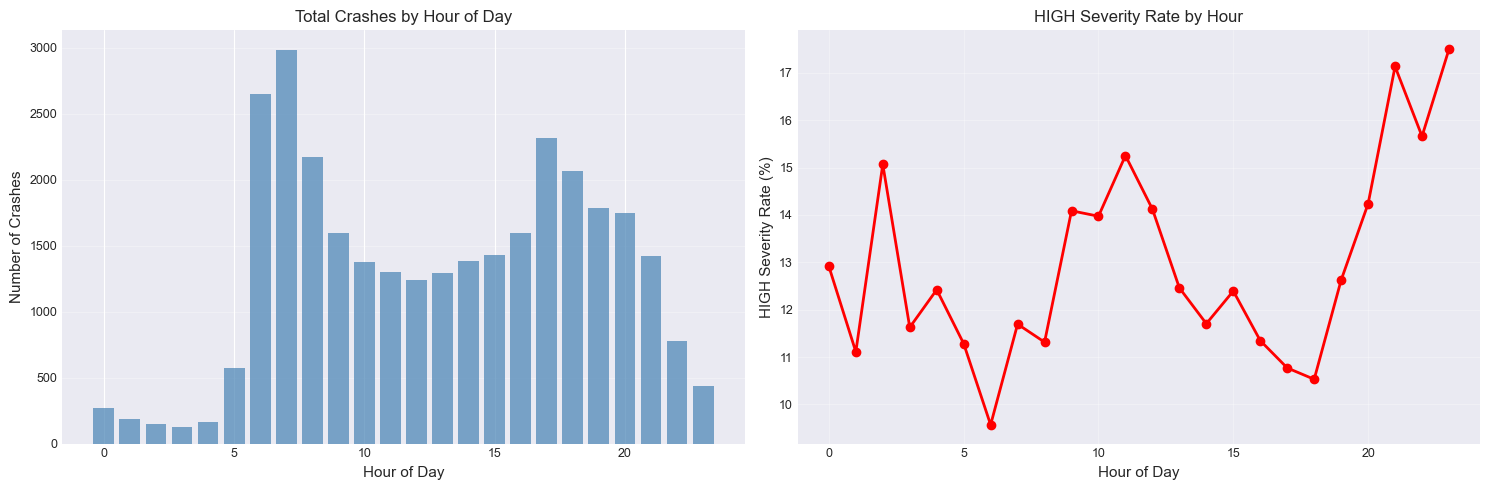


 Figure saved: temporal_hourly_patterns.png

DAY OF WEEK CRASH DISTRIBUTION
           total_crashes  high_severity_crashes  high_severity_rate
day_name                                                           
Monday              4586                    605           13.192324
Tuesday             4730                    583           12.325581
Wednesday           4604                    520           11.294526
Thursday            4537                    538           11.858056
Friday              5058                    610           12.060103
Saturday            4395                    550           12.514221
Sunday              3154                    478           15.155358


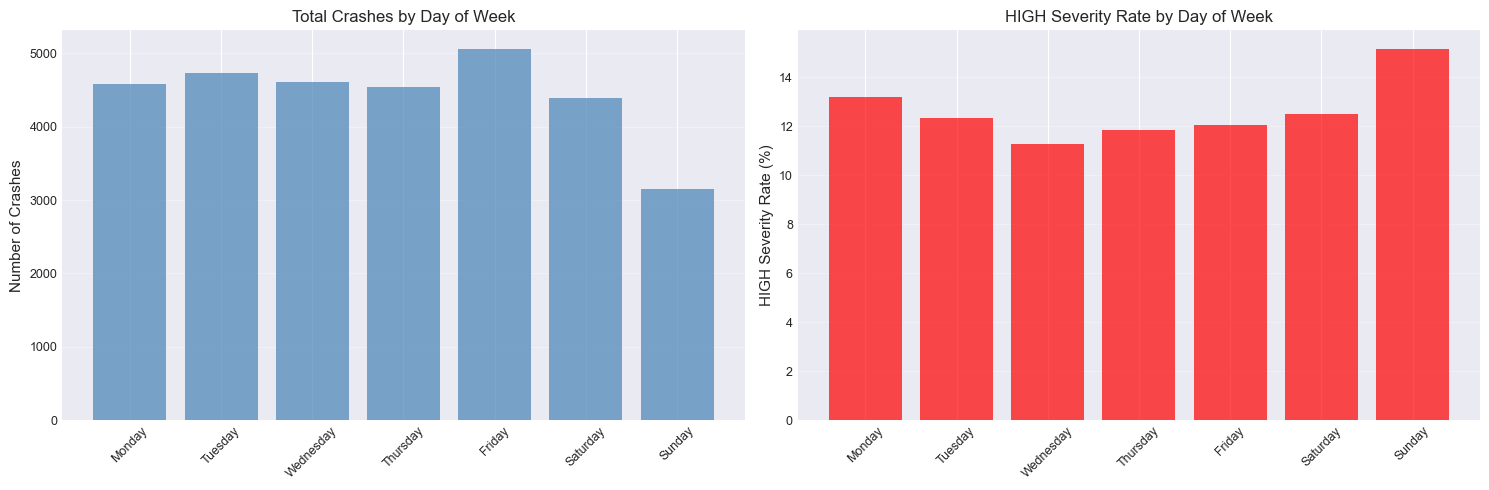


 Figure saved: temporal_daily_patterns.png

MONTHLY CRASH DISTRIBUTION
       total_crashes  high_severity_crashes  high_severity_rate
month                                                          
1               2455                    288           11.731161
2               2566                    313           12.197973
3               2887                    389           13.474195
4               2351                    286           12.165036
5               2744                    327           11.916910
6               2556                    344           13.458529
7               2672                    327           12.238024
8               2528                    315           12.460443
9               2416                    324           13.410596
10              2571                    279           10.851809
11              2696                    357           13.241840
12              2622                    335           12.776506


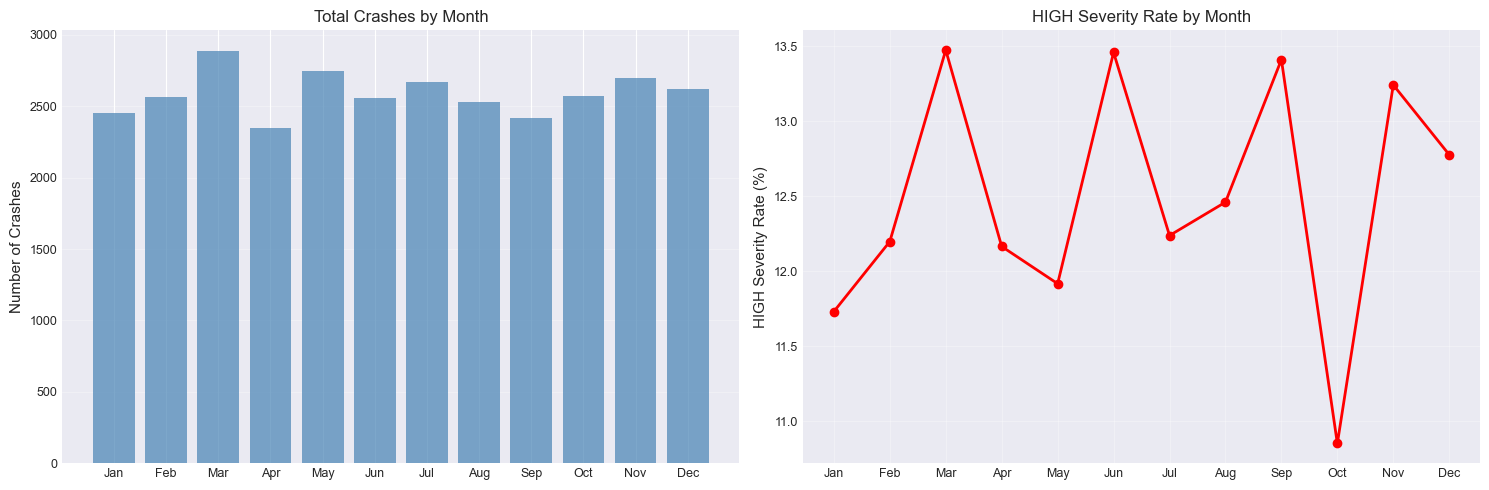


 Figure saved: temporal_monthly_patterns.png

KEY TEMPORAL INSIGHTS

1. PEAK CRASH HOUR: 7:00 with 2,984 crashes
2. MOST DANGEROUS HOUR: 23:00 (HIGH severity rate: 17.50%)
3. WEEKEND HIGH RATE: 13.62%
4. WEEKDAY HIGH RATE: 12.15%
5. WEEKEND vs WEEKDAY: Weekend MORE dangerous

 Temporal pattern analysis complete
 Dataset now has 18 columns


In [6]:
"""
SECTION 4: Temporal Pattern Analysis

Analyze crash patterns across time dimensions (hour, day of week, month).
Temporal features are crucial predictors in accident severity models.
These features are ALWAYS available at dispatch time (from call timestamp).
"""

# Extract temporal features from crash_datetime
df['hour'] = df['crash_datetime'].dt.hour
df['day_of_week'] = df['crash_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_name'] = df['crash_datetime'].dt.day_name()
df['month'] = df['crash_datetime'].dt.month
df['year'] = df['crash_datetime'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Saturday=5, Sunday=6

print("="*70)
print("TEMPORAL FEATURES CREATED")
print("="*70)
print(f"Date range: {df['year'].min()} to {df['year'].max()}")
print(f"Total years: {df['year'].nunique()}")
print("\n✓ Added features: hour, day_of_week, day_name, month, year, is_weekend")


# ============================================================================
# HOURLY PATTERN ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("HOURLY CRASH DISTRIBUTION")
print("="*70)

hourly_dist = df.groupby('hour').agg({
    'crash_id': 'count',
    'severity_binary': lambda x: (x == 'HIGH').sum()
}).rename(columns={'crash_id': 'total_crashes', 'severity_binary': 'high_severity_crashes'})

hourly_dist['high_severity_rate'] = (hourly_dist['high_severity_crashes'] / 
                                      hourly_dist['total_crashes'] * 100)

print(hourly_dist.to_string())

# Visualize hourly patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total crashes by hour
axes[0].bar(hourly_dist.index, hourly_dist['total_crashes'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Crashes')
axes[0].set_title('Total Crashes by Hour of Day')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: HIGH severity rate by hour
axes[1].plot(hourly_dist.index, hourly_dist['high_severity_rate'], 
             marker='o', linewidth=2, markersize=6, color='red')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('HIGH Severity Rate (%)')
axes[1].set_title('HIGH Severity Rate by Hour')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/temporal_hourly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: temporal_hourly_patterns.png")


# ============================================================================
# DAY OF WEEK PATTERN ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("DAY OF WEEK CRASH DISTRIBUTION")
print("="*70)

daily_dist = df.groupby('day_name').agg({
    'crash_id': 'count',
    'severity_binary': lambda x: (x == 'HIGH').sum()
}).rename(columns={'crash_id': 'total_crashes', 'severity_binary': 'high_severity_crashes'})

daily_dist['high_severity_rate'] = (daily_dist['high_severity_crashes'] / 
                                     daily_dist['total_crashes'] * 100)

# Reorder days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_dist = daily_dist.reindex(day_order)

print(daily_dist.to_string())

# Visualize daily patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total crashes by day
axes[0].bar(range(7), daily_dist['total_crashes'], color='steelblue', alpha=0.7)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_order, rotation=45)
axes[0].set_ylabel('Number of Crashes')
axes[0].set_title('Total Crashes by Day of Week')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: HIGH severity rate by day
axes[1].bar(range(7), daily_dist['high_severity_rate'], color='red', alpha=0.7)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_order, rotation=45)
axes[1].set_ylabel('HIGH Severity Rate (%)')
axes[1].set_title('HIGH Severity Rate by Day of Week')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/temporal_daily_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: temporal_daily_patterns.png")



# ============================================================================
# MONTHLY PATTERN ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("MONTHLY CRASH DISTRIBUTION")
print("="*70)

monthly_dist = df.groupby('month').agg({
    'crash_id': 'count',
    'severity_binary': lambda x: (x == 'HIGH').sum()
}).rename(columns={'crash_id': 'total_crashes', 'severity_binary': 'high_severity_crashes'})

monthly_dist['high_severity_rate'] = (monthly_dist['high_severity_crashes'] / 
                                       monthly_dist['total_crashes'] * 100)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print(monthly_dist.to_string())

# Visualize monthly patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total crashes by month
axes[0].bar(range(1, 13), monthly_dist['total_crashes'], color='steelblue', alpha=0.7)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].set_ylabel('Number of Crashes')
axes[0].set_title('Total Crashes by Month')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: HIGH severity rate by month
axes[1].plot(range(1, 13), monthly_dist['high_severity_rate'], 
             marker='o', linewidth=2, markersize=6, color='red')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_ylabel('HIGH Severity Rate (%)')
axes[1].set_title('HIGH Severity Rate by Month')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/temporal_monthly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: temporal_monthly_patterns.png")



# ============================================================================
# KEY TEMPORAL INSIGHTS SUMMARY
# ============================================================================
print("\n" + "="*70)
print("KEY TEMPORAL INSIGHTS")
print("="*70)

# Find peak crash hour
peak_hour = hourly_dist['total_crashes'].idxmax()
peak_hour_crashes = hourly_dist.loc[peak_hour, 'total_crashes']

# Find hour with highest HIGH severity rate
dangerous_hour = hourly_dist['high_severity_rate'].idxmax()
dangerous_hour_rate = hourly_dist.loc[dangerous_hour, 'high_severity_rate']

# Weekend vs weekday comparison
weekend_crashes = df[df['is_weekend'] == 1]
weekday_crashes = df[df['is_weekend'] == 0]
weekend_high_rate = (weekend_crashes['severity_binary'] == 'HIGH').mean() * 100
weekday_high_rate = (weekday_crashes['severity_binary'] == 'HIGH').mean() * 100

print(f"\n1. PEAK CRASH HOUR: {peak_hour}:00 with {peak_hour_crashes:,} crashes")
print(f"2. MOST DANGEROUS HOUR: {dangerous_hour}:00 (HIGH severity rate: {dangerous_hour_rate:.2f}%)")
print(f"3. WEEKEND HIGH RATE: {weekend_high_rate:.2f}%")
print(f"4. WEEKDAY HIGH RATE: {weekday_high_rate:.2f}%")
print(f"5. WEEKEND vs WEEKDAY: {'Weekend MORE dangerous' if weekend_high_rate > weekday_high_rate else 'Weekday MORE dangerous'}")

print("\n Temporal pattern analysis complete")
print(f" Dataset now has {len(df.columns)} columns")

SPATIAL PATTERN ANALYSIS

Geographic Bounds:
Latitude range:  -3.1000 to -0.5654
Longitude range: 36.2840 to 37.8795

Center point: (-1.2725, 36.8525)

CRASH DENSITY ANALYSIS (Grid-Based)

Total grid cells with crashes: 919
Grid cells with >100 crashes: 71
Grid cells with >50% HIGH rate: 55

TOP 10 CRASH HOTSPOTS (by volume)
                          lat_bin  lon_bin  total_crashes  high_severity_rate
grid_cell                                                                    
-1.29_36.82                 -1.29    36.82           1143           15.835521
-1.25_36.86                 -1.25    36.86            618            9.870550
-1.21_36.910000000000004    -1.21    36.91            613           13.866232
-1.22_36.89                 -1.22    36.89            600           10.000000
-1.26_36.84                 -1.26    36.84            590           12.033898
-1.32_36.83                 -1.32    36.83            587           16.524702
-1.24_36.87                 -1.24    36.87       

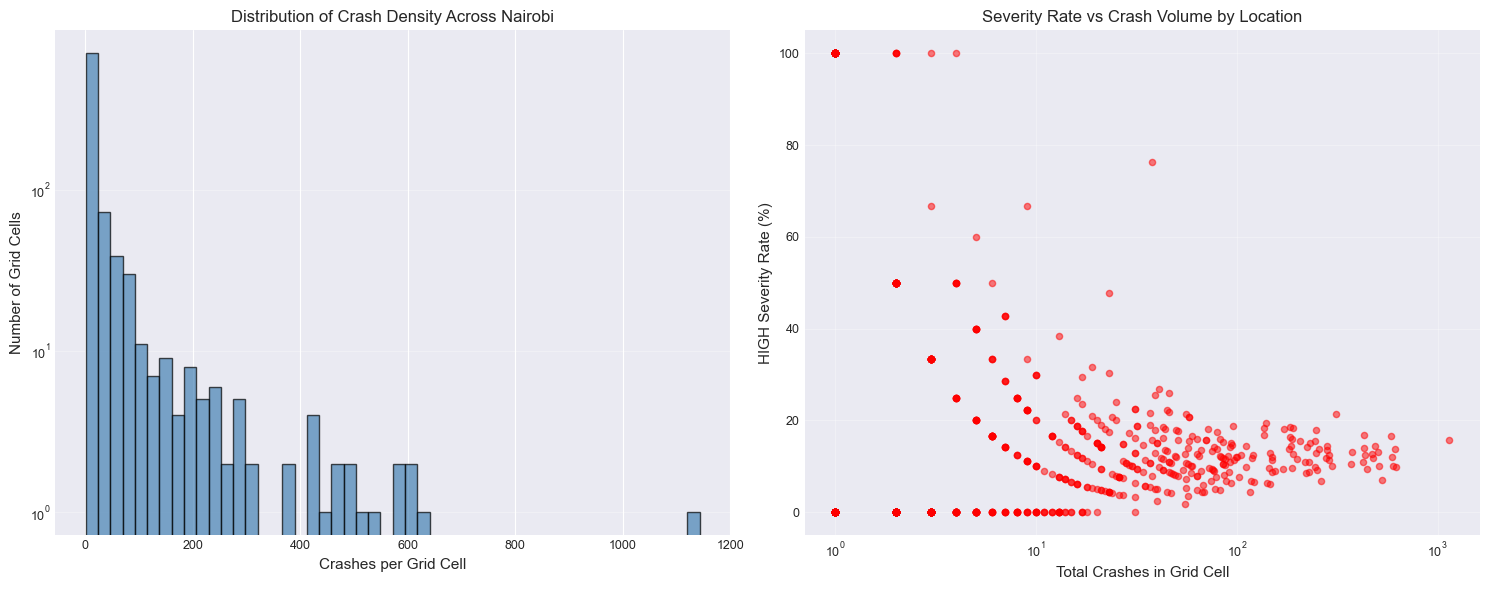


 Figure saved: spatial_density_analysis.png

CREATING HISTORICAL SPATIAL RISK FEATURES

 Historical spatial features created:
1. crashes_at_location: Total historical crashes in this 1km grid cell
2. high_rate_at_location: Historical HIGH severity rate (%) at this location
3. location_risk_category: Risk classification based on historical severity

Location Risk Category Distribution:
location_risk_category
LOW_RISK           9097
MEDIUM_RISK       13029
HIGH_RISK          6208
VERY_HIGH_RISK     1519
Name: count, dtype: int64

KEY SPATIAL INSIGHTS

1. HOTTEST HOTSPOT: 1,143 crashes at (-1.290, 36.820)
2. SPATIAL HETEROGENEITY: Crash density varies 1143x across city
3. GRID CELLS ANALYZED: 919 unique 1km x 1km areas
4. MEAN CRASHES PER CELL: 33.8
5. MEDIAN CRASHES PER CELL: 3

 Spatial pattern analysis complete
 Dataset now has 24 columns


In [9]:
"""
SECTION 5: Spatial Pattern Analysis

Analyze crash distribution across geographic space in Nairobi.
Spatial features are critical for dispatch because location determines:
1. Response time (distance to hospitals)
2. Historical risk at location
3. Road type and infrastructure quality

All spatial features are available at dispatch time from GPS coordinates.
"""

import numpy as np

print("="*70)
print("SPATIAL PATTERN ANALYSIS")
print("="*70)

# Basic geographic statistics
print("\nGeographic Bounds:")
print(f"Latitude range:  {df['latitude'].min():.4f} to {df['latitude'].max():.4f}")
print(f"Longitude range: {df['longitude'].min():.4f} to {df['longitude'].max():.4f}")
print(f"\nCenter point: ({df['latitude'].mean():.4f}, {df['longitude'].mean():.4f})")


# ============================================================================
# CRASH DENSITY ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("CRASH DENSITY ANALYSIS (Grid-Based)")
print("="*70)

# Create spatial grid (0.01 degree ~ 1.1 km at equator)
df['lat_bin'] = (df['latitude'] // 0.01) * 0.01
df['lon_bin'] = (df['longitude'] // 0.01) * 0.01
df['grid_cell'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)

# Calculate crashes per grid cell
grid_stats = df.groupby('grid_cell').agg({
    'crash_id': 'count',
    'severity_binary': lambda x: (x == 'HIGH').sum(),
    'lat_bin': 'first',
    'lon_bin': 'first'
}).rename(columns={
    'crash_id': 'total_crashes',
    'severity_binary': 'high_severity_crashes'
})

grid_stats['high_severity_rate'] = (grid_stats['high_severity_crashes'] / 
                                     grid_stats['total_crashes'] * 100)

print(f"\nTotal grid cells with crashes: {len(grid_stats)}")
print(f"Grid cells with >100 crashes: {(grid_stats['total_crashes'] > 100).sum()}")
print(f"Grid cells with >50% HIGH rate: {(grid_stats['high_severity_rate'] > 50).sum()}")

# Find hotspots
print("\n" + "="*70)
print("TOP 10 CRASH HOTSPOTS (by volume)")
print("="*70)
top_hotspots = grid_stats.nlargest(10, 'total_crashes')
print(top_hotspots[['lat_bin', 'lon_bin', 'total_crashes', 'high_severity_rate']].to_string())

# Find most dangerous locations
print("\n" + "="*70)
print("TOP 10 MOST DANGEROUS LOCATIONS (by HIGH severity rate, min 20 crashes)")
print("="*70)
dangerous_locations = grid_stats[grid_stats['total_crashes'] >= 20].nlargest(10, 'high_severity_rate')
print(dangerous_locations[['lat_bin', 'lon_bin', 'total_crashes', 'high_severity_rate']].to_string())



# ============================================================================
# SPATIAL STATISTICS VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("SPATIAL DENSITY VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Histogram of crashes per grid cell
axes[0].hist(grid_stats['total_crashes'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Crashes per Grid Cell')
axes[0].set_ylabel('Number of Grid Cells')
axes[0].set_title('Distribution of Crash Density Across Nairobi')
axes[0].set_yscale('log')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: HIGH severity rate vs crash volume
axes[1].scatter(grid_stats['total_crashes'], grid_stats['high_severity_rate'], 
                alpha=0.5, s=20, color='red')
axes[1].set_xlabel('Total Crashes in Grid Cell')
axes[1].set_ylabel('HIGH Severity Rate (%)')
axes[1].set_title('Severity Rate vs Crash Volume by Location')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/spatial_density_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: spatial_density_analysis.png")



# ============================================================================
# CALCULATE HISTORICAL RISK FEATURES (for each crash location)
# ============================================================================
print("\n" + "="*70)
print("CREATING HISTORICAL SPATIAL RISK FEATURES")
print("="*70)

# Map grid-level statistics back to individual crashes
df['crashes_at_location'] = df['grid_cell'].map(grid_stats['total_crashes'])
df['high_rate_at_location'] = df['grid_cell'].map(grid_stats['high_severity_rate'])

# Create risk categories
df['location_risk_category'] = pd.cut(df['high_rate_at_location'], 
                                       bins=[0, 10, 15, 20, 100],
                                       labels=['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK', 'VERY_HIGH_RISK'])

print("\n Historical spatial features created:")
print("1. crashes_at_location: Total historical crashes in this 1km grid cell")
print("2. high_rate_at_location: Historical HIGH severity rate (%) at this location")
print("3. location_risk_category: Risk classification based on historical severity")

print("\nLocation Risk Category Distribution:")
print(df['location_risk_category'].value_counts().sort_index())



# ============================================================================
# KEY SPATIAL INSIGHTS
# ============================================================================
print("\n" + "="*70)
print("KEY SPATIAL INSIGHTS")
print("="*70)

max_crash_cell = grid_stats['total_crashes'].max()
max_crash_location = grid_stats.loc[grid_stats['total_crashes'].idxmax()]

print(f"\n1. HOTTEST HOTSPOT: {max_crash_cell:,} crashes at ({max_crash_location['lat_bin']:.3f}, {max_crash_location['lon_bin']:.3f})")
print(f"2. SPATIAL HETEROGENEITY: Crash density varies {max_crash_cell}x across city")
print(f"3. GRID CELLS ANALYZED: {len(grid_stats):,} unique 1km x 1km areas")
print(f"4. MEAN CRASHES PER CELL: {grid_stats['total_crashes'].mean():.1f}")
print(f"5. MEDIAN CRASHES PER CELL: {grid_stats['total_crashes'].median():.0f}")

print("\n Spatial pattern analysis complete")
print(f" Dataset now has {len(df.columns)} columns")

In [10]:
"""
SECTION 6: Save Labeled Dataset

Save the dataset with severity labels and temporal/spatial features.
This becomes the starting point for feature engineering in the next notebook.

Current features (24 total):
- Original: 10 columns from World Bank
- Severity: 2 columns (4-class and binary)
- Temporal: 6 columns (hour, day, month, year, weekend, day_name)
- Spatial: 6 columns (grid, risk features)
"""

print("="*70)
print("DATASET SUMMARY BEFORE SAVING")
print("="*70)

# Display column inventory
print(f"\nTotal columns: {len(df.columns)}")
print("\nColumn categories:")

original_cols = ['crash_id', 'crash_datetime', 'crash_date', 'latitude', 'longitude', 
                 'n_crash_reports', 'contains_fatality_words', 'contains_pedestrian_words',
                 'contains_matatu_words', 'contains_motorcycle_words']

severity_cols = ['severity_4class', 'severity_binary']

temporal_cols = ['hour', 'day_of_week', 'day_name', 'month', 'year', 'is_weekend']

spatial_cols = ['lat_bin', 'lon_bin', 'grid_cell', 'crashes_at_location', 
                'high_rate_at_location', 'location_risk_category']

print(f"\n1. Original (World Bank):  {len(original_cols)} columns")
print(f"2. Severity labels:        {len(severity_cols)} columns")
print(f"3. Temporal features:      {len(temporal_cols)} columns")
print(f"4. Spatial features:       {len(spatial_cols)} columns")

# Display data quality
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

print("\n Missing values:")
missing_counts = df.isnull().sum()
if missing_counts.sum() == 0:
    print(" No missing values!")
else:
    print(missing_counts[missing_counts > 0])

print("\n Duplicate rows:")
duplicates = df.duplicated().sum()
print(f"  {' No duplicates!' if duplicates == 0 else f'✗ {duplicates} duplicates found'}")

# Display final statistics
print("\n" + "="*70)
print("FINAL DATASET STATISTICS")
print("="*70)

print(f"\nTotal crashes: {len(df):,}")
print(f"Date range: {df['crash_date'].min().date()} to {df['crash_date'].max().date()}")
print(f"Geographic coverage: {len(df['grid_cell'].unique())} unique 1km grid cells")

print("\n Binary severity distribution:")
print(df['severity_binary'].value_counts())
print(f"\nClass imbalance ratio (LOW:HIGH): {(df['severity_binary']=='LOW').sum() / (df['severity_binary']=='HIGH').sum():.2f}:1")

# Save to CSV
output_path = '../data/processed/labeled_crashes.csv'
df.to_csv(output_path, index=False)

print("\n" + "="*70)
print("DATASET SAVED SUCCESSFULLY")
print("="*70)
print(f"\nOutput file: {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

# Save column reference for later use
column_reference = {
    'original': original_cols,
    'severity': severity_cols,
    'temporal': temporal_cols,
    'spatial': spatial_cols
}

print("\n Data exploration complete!")
print(" Ready for feature engineering in next notebook")
print(f"\n{len(df.columns)} features will be available for model training:")
print("  - 10 original keyword flags")
print("  - 2 severity labels")
print("  - 6 temporal features")
print("  - 6 spatial features")

DATASET SUMMARY BEFORE SAVING

Total columns: 24

Column categories:

1. Original (World Bank):  10 columns
2. Severity labels:        2 columns
3. Temporal features:      6 columns
4. Spatial features:       6 columns

DATA QUALITY CHECK

 Missing values:
location_risk_category    1211
dtype: int64

 Duplicate rows:
   No duplicates!

FINAL DATASET STATISTICS

Total crashes: 31,064
Date range: 2012-08-08 to 2023-07-12
Geographic coverage: 919 unique 1km grid cells

 Binary severity distribution:
severity_binary
LOW     27180
HIGH     3884
Name: count, dtype: int64

Class imbalance ratio (LOW:HIGH): 7.00:1

DATASET SAVED SUCCESSFULLY

Output file: ../data/processed/labeled_crashes.csv
File size: 5.11 MB
Rows: 31,064
Columns: 24

 Data exploration complete!
 Ready for feature engineering in next notebook

24 features will be available for model training:
  - 10 original keyword flags
  - 2 severity labels
  - 6 temporal features
  - 6 spatial features
